# NewRad2023

In [1]:
import numpy as np
import luxpy as lx
from luxpy import _CIE_ILLUMINANTS, SPD, _CMF
from empir19nrm02 import _SPD, _RES

from empir19nrm02.tools.help import strd, label_font_size, plot_cmf2, save_fig, get_target, label_management, \
    quantil, display_responsivity
from empir19nrm02.tools import plotCorrelation
from empir19nrm02.MC import load_from_csv
from empir19nrm02.spectral.spectral_data import _CORR_PATH
from matplotlib import pyplot
from empir19nrm02.MC import StatDataVector

## Some settings for the processing

In [2]:
# Calibration illuminant
S_C = 'A'
#S_C = 'L41'
print( 'Calibration with: ', S_C)

# Select the color space for evaluation
cieobs = '1931_2'
print('Color matching functions from:', cieobs)

# display the colorbar in some diagrams
spectrum_color = False

#select the wavelength range for evaluation (with model LEDs)
wl_check = np.arange(405, 700+1, 5)

#define the wavelength scale for the calculation
wl_calc = lx.getwlr([380,780,1])

# outdir
out_dir = 'NewRad2023'

Calibration with:  A
Color matching functions from: 1931_2


VLDetectors


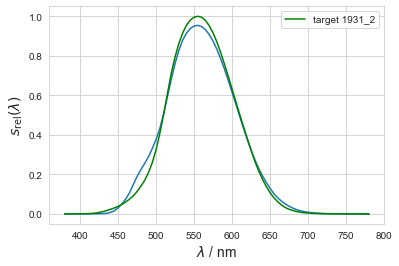

f1prime=7.3 %


In [3]:
_detectors=_RES['VLDetectors']['S']['data'].copy()
# the detector from Yasaman (eMail: 230317)
det_number = 128
detector = np.vstack((_detectors[0], _detectors[det_number]))
detector_norm, f1p = display_responsivity('VLDetectors', detector, cieobs=cieobs, s_target_index=2, out_dir=out_dir, S_C=S_C, spectrum_color=spectrum_color, plots=['plot1'])
print( f'f1prime={f1p[0]*100:0.2} %')

## A more general way to caculate SMCF
# $F(S_\mathrm{Z}(\lambda),S_\mathrm{C}(\lambda) = \frac{F_\mathrm{C,N}}{F_\mathrm{C,D}}\frac{F_\mathrm{M,N}}{F_\mathrm{M,D}}$

# $F_\mathrm{C,N} = \int{S_\mathrm{C}(\lambda)s(\lambda)\mathrm{d}\lambda}$
# $F_\mathrm{C,D} = \int{S_\mathrm{C}(\lambda)s_\mathrm{T}(\lambda)\mathrm{d}\lambda}$
# $F_\mathrm{M,N} = \int{S_\mathrm{Z}(\lambda)s_\mathrm{T}(\lambda)\mathrm{d}\lambda}$
# $F_\mathrm{M,D} = \int{S_\mathrm{Z}(\lambda)s(\lambda)\mathrm{d}\lambda}$

# $F(S_\mathrm{Z}(\lambda),S_\mathrm{C}(\lambda) = \underbrace{\frac{\int{S_\mathrm{C}(\lambda)s(\lambda)\mathrm{d}\lambda}}{\int{S_\mathrm{C}(\lambda)s_\mathrm{T}(\lambda)\mathrm{d}\lambda}}}_{\text{Calibration}}\underbrace{\frac{\int{S_\mathrm{Z}(\lambda)s_\mathrm{T}(\lambda)\mathrm{d}\lambda}}{\int{S_\mathrm{Z}(\lambda)s(\lambda)\mathrm{d}\lambda}}}_{\text{Measurement}}$

| Symbol | Description |
| :-:    |  :-:   |
| $F(S_\mathrm{Z}(\lambda)$ | SD DUT |
| $F(S_\mathrm{C}(\lambda)$ | SD Calibration |
| $s(\lambda)$ | (rel.) spectral responsivity of detetor |
| $s_\mathrm{T}(\lambda)$ |  spectral responsivity of the target function (e.g. $V(\lambda)$ |


In [4]:
g_S_C_ref = None
g_S_Z_ref = None
g_s_detector_ref = None

def smcf_set_ref( _S_C_ref, _S_Z_ref, _s_detector_ref):
    global g_S_C_ref, g_S_Z_ref, g_s_detector_ref

    if isinstance(_S_C_ref,str):
        g_S_C_ref = _CIE_ILLUMINANTS[_S_C_ref].copy()
    else:
        if isinstance(_S_C_ref, SPD):
            g_S_C_ref = np.vstack( (_S_C_ref.wl, _S_C_ref.value))
        else:
            g_S_C_ref = _S_C_ref.copy()

    if isinstance(_S_Z_ref,str):
        g_S_Z_ref = _CIE_ILLUMINANTS[_S_Z_ref].copy()
    else:
        if isinstance(_S_Z_ref, SPD):
            g_S_Z_ref = np.vstack( (_S_Z_ref.wl, _S_Z_ref.value))
        else:
            g_S_Z_ref = _S_Z_ref.copy()
    if isinstance(_S_Z_ref, SPD):
        g_s_detector_ref = np.vstack( (_s_detector_ref.wl, _s_detector_ref.value))
    else:
        g_s_detector_ref = _s_detector_ref.copy()
    return

def smcf_calculation( S_Z, s_detector, S_C='A', cieobs='1931_2', s_target_index=2, interp_kind = 'S', use_ref = False, use_global_ref = False):

    # Get illuminant:
    if isinstance(S_C,str): S_C = _CIE_ILLUMINANTS[S_C].copy()

    s_target = _CMF[cieobs]['bar'][[0,s_target_index]].copy() if isinstance(cieobs, str) else cieobs[[0,s_target_index]].copy()

    wlr = s_detector[0] # get wavelength range from the detector data
    dl = lx.getwld(wlr) # wavelength differences (unequal wavelength spacings are taken into account)
    dl = dl*np.ones_like(wlr) # ensure array like for matrix multiplication

    # Interpolate measured spectrum to desired wavelength range:
    s_target = lx.cie_interp(s_target, wlr, kind = interp_kind)[1:]
    S_C = lx.cie_interp(S_C, wlr, kind = interp_kind)[1:]
    S_Z = lx.cie_interp(S_Z, wlr, kind = interp_kind)[1:]
    s_detector = s_detector[1:]

    # taking the first information as reference
    if use_ref:
        if use_global_ref:
            S_C_ref = lx.cie_interp(g_S_C_ref, wlr, kind = interp_kind)[1:]
            S_Z_ref = lx.cie_interp(g_S_Z_ref, wlr, kind = interp_kind)[1:]
            s_detector_ref = lx.cie_interp(g_s_detector_ref, wlr, kind = interp_kind)[1:]
            S_C_ref = np.tile(S_C_ref[0],(S_C.shape[0],1))
            S_Z_ref = np.tile(S_Z_ref[0],(S_Z.shape[0],1))
            s_detector_ref = np.tile(s_detector_ref[0],(s_detector.shape[0],1))
        else:
            S_C_ref = np.tile(S_C[0],(S_C.shape[0],1))
            S_Z_ref = np.tile(S_Z[0],(S_Z.shape[0],1))
            s_detector_ref = np.tile(s_detector[0],(s_detector.shape[0],1))
    else:
        S_C_ref = S_C
        S_Z_ref = S_Z
        s_detector_ref = s_detector

    use_luxpy = False
    F_M_N = 1
    F_M_D = 1
    F_C_N = 1
    F_C_D = 1
    if use_luxpy:
        # Calculate s_rel:
        s_rel = (s_target @ (S_C_ref*dl).T) / (s_detector_ref @ (S_C*dl).T) * s_detector
        # Calculate spectral mismatch correction factors:
        F = (S_Z_ref @ (s_target*dl).T) / (S_Z @ (s_rel*dl).T)
    else:
        # Calculate spectral mismatch correction factors:
        F_M_N = (S_Z_ref @ (s_target*dl).T)
        F_M_D = (S_Z @ (s_detector*dl).T)
        F_C_N = (S_C @ (s_detector_ref*dl).T)
        F_C_D = (S_C_ref @ (s_target*dl).T)
        F = F_C_N/F_C_D * F_M_N/F_M_D

    return F, F_C_N, F_C_D, F_M_N, F_M_D

In [5]:
def plotMCResult( wl, mcVarData:StatDataVector, title=None, fig = None, ax1 = None, ax2 = None, diagnumber=0):
    bFirst = False
    if not fig:
        fig, ax1 = pyplot.subplots()
        ax2 = ax1.twinx()
        color1 = 'r-'
        color2 = 'g-'
    else:
        if diagnumber == 1:
            color1 = 'r--'
            color2 = 'g--'
        else:
            color1 = 'r-.'
            color2 = 'g-.'

    if not title:
        title = ''
    ax1.plot(wl, mcVarData.v_mean/np.max(mcVarData.v_mean), color1, label= title + ' $s_{\mathrm{rel}}(\lambda)$')
    ax2.plot(wl,mcVarData.v_std / mcVarData.v_mean, color2, label= title + ' $u_{\mathrm{rel}}(s_{\mathrm{rel}})(\lambda)$')
    ax1.set_xlabel(strd['xlambda'])
    ax1.set_ylabel('Signal / A.U', color = 'red')
    ax2.set_ylabel('$\sigma_{\mathrm{rel}}$', color = 'green')
    if title:
        ax1.set_title(title)
    fig.legend()
    return fig, ax1, ax2

# Use FEL Lamp-1 from the PTB set

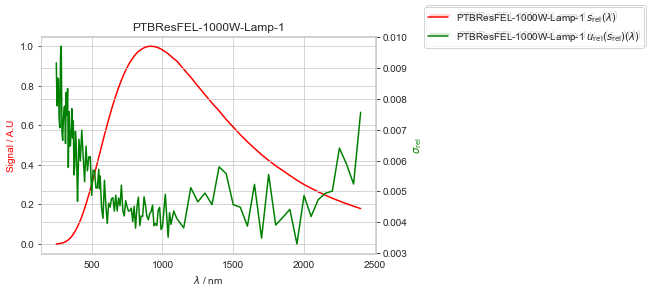

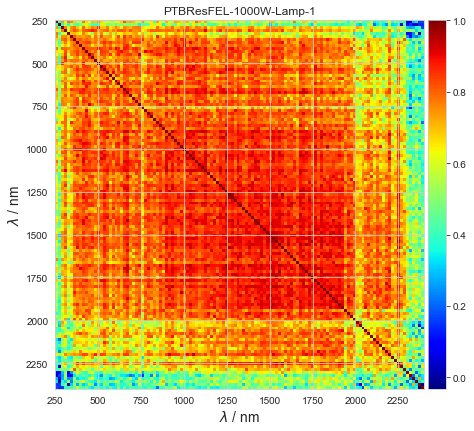

In [6]:
str_file = 'PTBResFEL-1000W-Lamp-1'
wlFEL, mcVectorVarFEL = load_from_csv(_CORR_PATH + '/' + str_file)
_spectra = np.vstack((wlFEL, mcVectorVarFEL.setData.v_mean))

fig, ax1, ax2 = plotMCResult(wlFEL, mcVectorVarFEL.setData, str_file)
fig.legend(bbox_to_anchor=(1,1), loc="upper left")
plotCorrelation(mcVectorVarFEL.setData.corr_matrix, wlFEL, str_file)

In [7]:
SMCF_A = lx.spectral_mismatch_and_uncertainty.get_spectral_mismatch_correction_factors( _spectra, detector, S_C='A', cieobs='1931_2', s_target_index=2)
print( f'SMCF for calibration with standard illuminant A: {SMCF_A[0][0]:.6}')
SMCF_L41 = lx.spectral_mismatch_and_uncertainty.get_spectral_mismatch_correction_factors( _spectra, detector, S_C='L41', cieobs='1931_2', s_target_index=2)
print( f'SMCF for calibration with standard illuminant L41: {SMCF_L41[0][0]:.6}')

SMCF for calibration with standard illuminant A: 1.00049
SMCF for calibration with standard illuminant L41: 0.984233


# Check the more general SMCF calculation

In [8]:
F, F_C_N, F_C_D, F_M_N, F_M_D = smcf_calculation( _spectra, detector, S_C='A', cieobs='1931_2', s_target_index=2)
print(f'CIE standard illuminant A: {F}, {F_C_N}, {F_C_D}, {F_M_N}, {F_M_D} --> reduced: {F_M_N/F_M_D}')

F, F_C_N, F_C_D, F_M_N, F_M_D = smcf_calculation( _spectra, detector, S_C='L41', cieobs='1931_2', s_target_index=2)
print(f'CIE reference source L41: {F}, {F_C_N}, {F_C_D}, {F_M_N}, {F_M_D} --> reduced: {F_M_N/F_M_D}')


CIE standard illuminant A: [[1.0005e+00]], [[1.1313e+04]], [[1.0790e+04]], [[5.0611e+00]], [[5.3041e+00]] --> reduced: [[9.5418e-01]]
CIE reference source L41: [[9.8423e-01]], [[1.5102e+03]], [[1.4641e+03]], [[5.0611e+00]], [[5.3041e+00]] --> reduced: [[9.5418e-01]]


# MCS

In [26]:
from empir19nrm02.MC.MCSim import MCVectorVar, NameUnit, DistributionParam, MCSimulation,noise_list_default

trials = 10
wl = detector[0]

def runSimpleMC( detectorMC, spectraMC, SMCF, NumberTrials, model_single):
    input = [detectorMC, spectraMC]
    output = [SMCF]

    sim = MCSimulation(trials=NumberTrials)
    sim.set_input_var(input)
    sim.set_output_var(output)
    sim.generate()
    sim.calculate_model( model_single)
    return sim.output_var

def model_single(detector, spectra):
    spectmp = np.vstack( (wl, spectra) )
    detectortmp = np.vstack( (wl, detector) )
    SMCF_g, F_C_N, F_C_D, F_M_N, F_M_D = smcf_calculation( spectmp, detectortmp, S_C='A', cieobs='1931_2', s_target_index=2, use_ref=False, use_global_ref=False)
    print(f'{SMCF_g[0][0]}, {F_C_N[0][0]}, {F_C_D[0][0]}, {F_M_N[0][0]}, {F_M_D[0][0]} --> reduced: {F_M_N[0][0]/F_M_D[0][0]}')
    SMCF_a = np.zeros(5)
    SMCF_a[0] = SMCF_g[0][0]
    SMCF_a[1] = F_C_N[0][0]
    SMCF_a[2] = F_C_D[0][0]
    SMCF_a[3] = F_M_N[0][0]
    SMCF_a[4] = F_M_D[0][0]
    return [SMCF_a]

Generate:
4.556645267964617, 3322.605710166334, 10789.521418223401, 78.56700063843195, 5.309719503232229 --> reduced: 14.796826949258849
4.556645267964617, 3322.605710166334, 10789.521418223401, 78.56700063843195, 5.309719503232229 --> reduced: 14.796826949258849
4.556645267964617, 3322.605710166334, 10789.521418223401, 78.56700063843195, 5.309719503232229 --> reduced: 14.796826949258849
4.556789700966129, 3320.23702110342, 10789.521418223401, 78.56700063843195, 5.305766020632542 --> reduced: 14.8078525010165
4.558390334700113, 3322.605710166334, 10789.521418223401, 78.6819164023977, 5.315450079329051 --> reduced: 14.80249371701924
4.558531555592406, 3320.23702110342, 10789.521418223401, 78.6819164023977, 5.311496137011006 --> reduced: 14.813512873356848
4.556874565164829, 3325.1795263589356, 10789.521418223401, 78.56700063843195, 5.313565226466618 --> reduced: 14.786117661093801
4.556188357377996, 3322.605710166334, 10789.521418223401, 78.63848472123993, 5.31508350639294 --> reduced: 

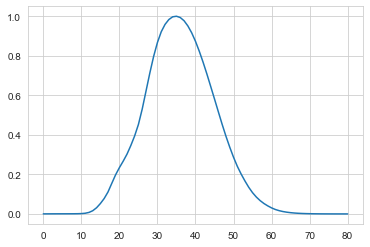

In [27]:
# run the MCS
SMCF_MC = MCVectorVar( name = NameUnit('SMCF', ''), elements=5)

detectorMC = MCVectorVar( name = NameUnit('Detector', 'A.U.'), elements=len(wl))
detectorMC.set_vector_param( detector[1], 0.01*detector[1])

pyplot.plot( detector[1])

# put the data at the same WL-Scale
if len(wl) != mcVectorVarFEL.elements:
    mcVectorVarFEL.interpolate(wl, wlFEL, trials=trials)

mcResult = runSimpleMC( mcVectorVarFEL, detectorMC, SMCF_MC, trials, model_single)


In [18]:
mcResult[0][0].val

array([[4.5575e+00, 3.3261e+03, 1.0790e+04, 7.8592e+01, 5.3161e+00],
       [4.5588e+00, 3.3275e+03, 1.0790e+04, 7.8592e+01, 5.3167e+00],
       [4.5529e+00, 3.3383e+03, 1.0790e+04, 7.8592e+01, 5.3409e+00],
       [4.5569e+00, 3.3298e+03, 1.0790e+04, 7.8592e+01, 5.3226e+00],
       [4.5556e+00, 3.3393e+03, 1.0790e+04, 7.8592e+01, 5.3392e+00],
       [4.5599e+00, 3.3066e+03, 1.0790e+04, 7.8592e+01, 5.2821e+00],
       [4.5569e+00, 3.3184e+03, 1.0790e+04, 7.8592e+01, 5.3044e+00],
       [4.5591e+00, 3.3240e+03, 1.0790e+04, 7.8592e+01, 5.3107e+00],
       [4.5588e+00, 3.3280e+03, 1.0790e+04, 7.8592e+01, 5.3175e+00],
       [4.5587e+00, 3.3167e+03, 1.0790e+04, 7.8592e+01, 5.2997e+00]])